In [5]:
!pip install pytube librosa moviepy pandas

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
import os
import tempfile
import subprocess
import librosa
import time
import pandas as pd
from IPython.display import display, Audio

# Install required packages if needed
try:
    subprocess.run(['which', 'yt-dlp'], check=True)
except:
    print("Installing yt-dlp...")
    subprocess.run(['pip', 'install', 'yt-dlp', '-q'], check=True)

# Load the YAMNet model from TensorFlow Hub
print("Loading YAMNet model...")
model = hub.load('https://tfhub.dev/google/yamnet/1')

def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_names = []
    with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            class_names.append(row['display_name'])
    return class_names

# Load class names
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

def ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate=16000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) /
                                  original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return desired_sample_rate, waveform

def download_youtube_audio(youtube_url, output_path=None):
    """Download audio from a YouTube video using yt-dlp."""
    print(f"Downloading audio from: {youtube_url}")
    try:
        # If no output path specified, create a temporary file
        if output_path is None:
            temp_dir = tempfile.gettempdir()
            output_path = os.path.join(temp_dir, f"youtube_audio_{int(time.time())}.wav")

        # First download as mp3 - much faster than downloading video
        temp_mp3 = os.path.join(tempfile.gettempdir(), f"temp_audio_{int(time.time())}.mp3")

        # Use yt-dlp command to download audio
        command = [
            'yt-dlp',
            '--no-playlist',
            '--extract-audio',
            '--audio-format', 'mp3',
            '--audio-quality', '0',  # Best quality
            '--output', temp_mp3,
            youtube_url
        ]

        print("Downloading audio stream...")
        process = subprocess.run(command, capture_output=True, text=True)

        if process.returncode != 0:
            raise Exception(f"Error downloading: {process.stderr}")

        # Get video title from yt-dlp output
        title_line = [line for line in process.stdout.split('\n') if 'Destination:' in line]
        if title_line:
            video_title = os.path.splitext(os.path.basename(title_line[0].split('Destination: ')[1]))[0]
        else:
            video_title = f"YouTube Video {int(time.time())}"

        # Convert to WAV format with 16kHz sample rate using librosa
        print("Converting to WAV format...")
        y, sr = librosa.load(temp_mp3, sr=16000, mono=True)

        # Save as WAV
        wavfile.write(output_path, 16000, (y * 32767).astype(np.int16))

        # Clean up temporary file
        try:
            os.remove(temp_mp3)
        except:
            pass

        print(f"Audio saved to: {output_path}")

        # Play a short sample
        sample_length = min(10 * sr, len(y))  # 10-second sample or full audio if shorter
        display(Audio(y[:sample_length], rate=sr))

        return output_path, video_title

    except Exception as e:
        print(f"Error downloading YouTube audio: {e}")
        return None, None

def analyze_audio_file(wav_file_path, segment_duration=5):
    """
    Analyze audio file using YAMNet and return results with timestamps.

    Args:
        wav_file_path: Path to the audio file
        segment_duration: Duration in seconds for each analysis segment

    Returns:
        DataFrame with timestamps and detected sound classes
    """
    # Load the audio file
    sample_rate, wav_data = wavfile.read(wav_file_path)
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

    # Normalize to values in [-1.0, 1.0]
    waveform = wav_data / tf.int16.max

    # Calculate total duration
    total_duration = len(wav_data) / sample_rate
    print(f"Total audio duration: {total_duration:.2f} seconds")

    # Calculate number of samples per segment
    samples_per_segment = int(segment_duration * sample_rate)

    # Calculate number of segments
    num_segments = int(np.ceil(len(waveform) / samples_per_segment))

    results = []

    # Process each segment
    print(f"Analyzing audio in {num_segments} segments...")
    for i in range(num_segments):
        if i % 10 == 0:  # Show progress for every 10 segments
            print(f"Processing segment {i+1}/{num_segments}...")

        start_sample = i * samples_per_segment
        end_sample = min(start_sample + samples_per_segment, len(waveform))

        # Get segment waveform
        segment_waveform = waveform[start_sample:end_sample]

        # Calculate timestamp
        start_time = start_sample / sample_rate
        end_time = end_sample / sample_rate

        # Run YAMNet on segment
        scores, embeddings, spectrogram = model(segment_waveform)

        # Get top 3 classes for this segment
        scores_np = scores.numpy()
        mean_scores = np.mean(scores_np, axis=0)
        top_indices = np.argsort(mean_scores)[::-1][:3]

        # Store results
        for idx in top_indices:
            class_name = class_names[idx]
            score = mean_scores[idx]
            if score > 0.1:  # Only include scores above threshold
                results.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'class_name': class_name,
                    'score': score
                })

    # Convert to DataFrame
    df = pd.DataFrame(results)
    return df

def format_time(seconds):
    """Format seconds into MM:SS format."""
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02d}:{seconds:02d}"

def visualize_results(results_df, video_title):
    """
    Visualize sound classification results.

    Args:
        results_df: DataFrame with analysis results
        video_title: Title of the video
    """
    if results_df.empty:
        print("No results to visualize.")
        return

    # Create visualization
    plt.figure(figsize=(15, 8))

    # Create a color map for different sounds
    unique_classes = results_df['class_name'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
    color_map = dict(zip(unique_classes, colors))

    # Plot sound events
    for i, (class_name, group) in enumerate(results_df.groupby('class_name')):
        segments = []
        for _, row in group.iterrows():
            segments.append((row['start_time'], row['end_time'] - row['start_time']))

        # Plot horizontal bars for each sound class
        for segment in segments:
            plt.barh(class_name, segment[1], left=segment[0], height=0.8,
                    color=color_map[class_name], alpha=0.7)

    # Set labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('Sound Class')
    plt.title(f'Sound Classification Timeline for: {video_title}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add time markers
    max_time = results_df['end_time'].max()
    time_ticks = np.arange(0, max_time + 60, 30)
    plt.xticks(time_ticks, [format_time(t) for t in time_ticks])

    plt.tight_layout()

    # Return the figure for display
    return plt.gcf()

def classify_youtube_audio(youtube_url):
    """
    Main function to download and classify sounds from a YouTube video.

    Args:
        youtube_url: URL of the YouTube video

    Returns:
        results: DataFrame with sound classification results
        fig: Matplotlib figure with visualization
    """
    # Download audio from YouTube
    wav_file_path, video_title = download_youtube_audio(youtube_url)

    if wav_file_path is None:
        print("Failed to download audio. Please check the URL and try again.")
        return None, None

    # Analyze the audio file
    results = analyze_audio_file(wav_file_path)

    # Display summary of detected sounds
    print("\nAnalysis complete! Detected sounds:")
    sound_summary = results.groupby('class_name')['score'].mean().sort_values(ascending=False).head(15)
    for sound, score in sound_summary.items():
        print(f"- {sound}: {score:.2f}")

    # Visualize results
    fig = visualize_results(results, video_title)

    # Clean up the temporary wav file
    os.remove(wav_file_path)

    return results, fig

# Example usage:
# results, fig = classify_youtube_audio("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
# fig.show()  # Display the visualization

Converting to WAV format...
Audio saved to: /tmp/youtube_audio_1747457984.wav


NameError: name 'analyze_audio_segments' is not defined

In [12]:
# Step 1: Install required packages
!pip install yt-dlp librosa tensorflow tensorflow-hub -q

print("✅ Packages installed")

# Step 2: Import libraries
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
import os
import tempfile
import subprocess
import librosa
import time
import pandas as pd
from IPython.display import display, Audio

print("✅ Libraries imported")

# Step 3: Load the YAMNet model
print("Loading YAMNet model (this may take a moment)...")
model = hub.load('https://tfhub.dev/google/yamnet/1')
print("✅ YAMNet model loaded")

# Step 4: Load class names
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_names = []
    with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            class_names.append(row['display_name'])
    return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)
print(f"✅ Loaded {len(class_names)} sound classes")

# Step 5: Define helper functions
def ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate=16000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) /
                                  original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return desired_sample_rate, waveform

def download_youtube_audio(youtube_url):
    """Download audio from a YouTube video using yt-dlp."""
    print(f"⏳ Downloading audio from: {youtube_url}")

    # Create a temporary file for the audio
    temp_dir = tempfile.gettempdir()
    output_path = os.path.join(temp_dir, f"youtube_audio_{int(time.time())}.wav")
    temp_mp3 = os.path.join(temp_dir, f"temp_audio_{int(time.time())}.mp3")

    try:
        # Use yt-dlp command to download audio as MP3
        command = [
            'yt-dlp',
            '-f', 'bestaudio',
            '--extract-audio',
            '--audio-format', 'mp3',
            '--audio-quality', '0',
            '--output', temp_mp3,
            youtube_url
        ]

        print("⏳ Running yt-dlp to download audio...")
        process = subprocess.run(command, capture_output=True, text=True)

        if process.returncode != 0:
            error_msg = process.stderr if process.stderr else "Unknown error"
            print(f"❌ yt-dlp error: {error_msg}")
            return None, None

        # Extract video title from output
        for line in process.stdout.split('\n'):
            if "Destination:" in line:
                video_title = line.split("Destination:")[1].strip()
                video_title = os.path.splitext(os.path.basename(video_title))[0]
                break
        else:
            video_title = f"YouTube Video {int(time.time())}"

        print(f"✅ Downloaded audio for: {video_title}")

        # Convert to WAV format with 16kHz sample rate using librosa
        print("⏳ Converting to 16kHz WAV format...")
        y, sr = librosa.load(temp_mp3, sr=16000, mono=True)

        # Save as WAV
        wavfile.write(output_path, 16000, (y * 32767).astype(np.int16))
        print("✅ Conversion complete")

        # Clean up temporary MP3 file
        os.remove(temp_mp3)

        return output_path, video_title

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None, None

def analyze_audio_segments(wav_file_path, segment_duration=5):
    """Analyze audio in segments and classify sounds."""
    print(f"⏳ Loading audio file: {wav_file_path}")

    # Load the audio file
    sample_rate, wav_data = wavfile.read(wav_file_path)
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

    # Normalize to values in [-1.0, 1.0]
    waveform = wav_data / tf.int16.max

    # Calculate total duration
    total_duration = len(wav_data) / sample_rate
    print(f"✅ Audio loaded - Duration: {total_duration:.2f} seconds")

    # Calculate segments
    samples_per_segment = int(segment_duration * sample_rate)
    num_segments = int(np.ceil(len(waveform) / samples_per_segment))

    results = []
    print(f"⏳ Analyzing {num_segments} segments...")

    # Process each segment
    for i in range(num_segments):
        if i % 5 == 0 or i == num_segments - 1:
            print(f"  Processing segment {i+1}/{num_segments}...")

        start_sample = i * samples_per_segment
        end_sample = min(start_sample + samples_per_segment, len(waveform))
        segment_waveform = waveform[start_sample:end_sample]

        # Calculate timestamp
        start_time = start_sample / sample_rate
        end_time = end_sample / sample_rate

        # Run YAMNet on segment
        scores, embeddings, spectrogram = model(segment_waveform)

        # Get top 3 classes for this segment
        scores_np = scores.numpy()
        mean_scores = np.mean(scores_np, axis=0)
        top_indices = np.argsort(mean_scores)[::-1][:3]

        # Store results
        for idx in top_indices:
            class_name = class_names[idx]
            score = mean_scores[idx]
            if score > 0.1:  # Only include scores above threshold
                results.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'class_name': class_name,
                    'score': score
                })

    print(f"✅ Analysis complete - {len(results)} sound events detected")
    return pd.DataFrame(results)

def format_time(seconds):
    """Format seconds into MM:SS format."""
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02d}:{seconds:02d}"

def visualize_sound_timeline(results_df, video_title):
    """Create a timeline visualization of detected sounds."""
    if results_df.empty:
        print("No results to visualize.")
        return

    print("⏳ Creating visualization...")

    # Create visualization
    plt.figure(figsize=(15, 8))

    # Create a color map for different sounds
    unique_classes = results_df['class_name'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
    color_map = dict(zip(unique_classes, colors))

    # Plot sound events
    for class_name, group in results_df.groupby('class_name'):
        segments = []
        for _, row in group.iterrows():
            segments.append((row['start_time'], row['end_time'] - row['start_time']))

        # Plot horizontal bars for each sound class
        for segment in segments:
            plt.barh(class_name, segment[1], left=segment[0], height=0.8,
                    color=color_map[class_name], alpha=0.7)

    # Set labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('Sound Class')
    plt.title(f'Sound Classification Timeline for: {video_title}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add time markers
    max_time = results_df['end_time'].max()
    time_ticks = np.arange(0, max_time + 60, 30)
    plt.xticks(time_ticks, [format_time(t) for t in time_ticks])

    plt.tight_layout()
    print("✅ Visualization created")
    return plt.gcf()

✅ Packages installed
✅ Libraries imported
Loading YAMNet model (this may take a moment)...
✅ YAMNet model loaded
✅ Loaded 521 sound classes


⏳ Downloading audio from: https://www.youtube.com/watch?v=7DzVIafBMpE
⏳ Running yt-dlp to download audio...
✅ Downloaded audio for: temp_audio_1747458356
⏳ Converting to 16kHz WAV format...
✅ Conversion complete
⏳ Loading audio file: /tmp/youtube_audio_1747458356.wav
✅ Audio loaded - Duration: 3992.45 seconds
⏳ Analyzing 799 segments...
  Processing segment 1/799...
  Processing segment 6/799...
  Processing segment 11/799...
  Processing segment 16/799...
  Processing segment 21/799...
  Processing segment 26/799...
  Processing segment 31/799...
  Processing segment 36/799...
  Processing segment 41/799...
  Processing segment 46/799...
  Processing segment 51/799...
  Processing segment 56/799...
  Processing segment 61/799...
  Processing segment 66/799...
  Processing segment 71/799...
  Processing segment 76/799...
  Processing segment 81/799...
  Processing segment 86/799...
  Processing segment 91/799...
  Processing segment 96/799...
  Processing segment 101/799...
  Processin

,Time,Sound,Confidence
0,00:00,Sound effect,0.170553
1,00:05,Speech,0.423841
2,00:10,Speech,0.211089
3,00:10,Water,0.109260
4,00:15,Speech,0.646967
5,00:20,Speech,0.719396
6,00:25,Speech,0.292167
7,00:30,Speech,0.419314
9,00:35,Vehicle,0.101704
8,00:35,Speech,0.333005



🧹 Cleaning up temporary files...
✅ Done!


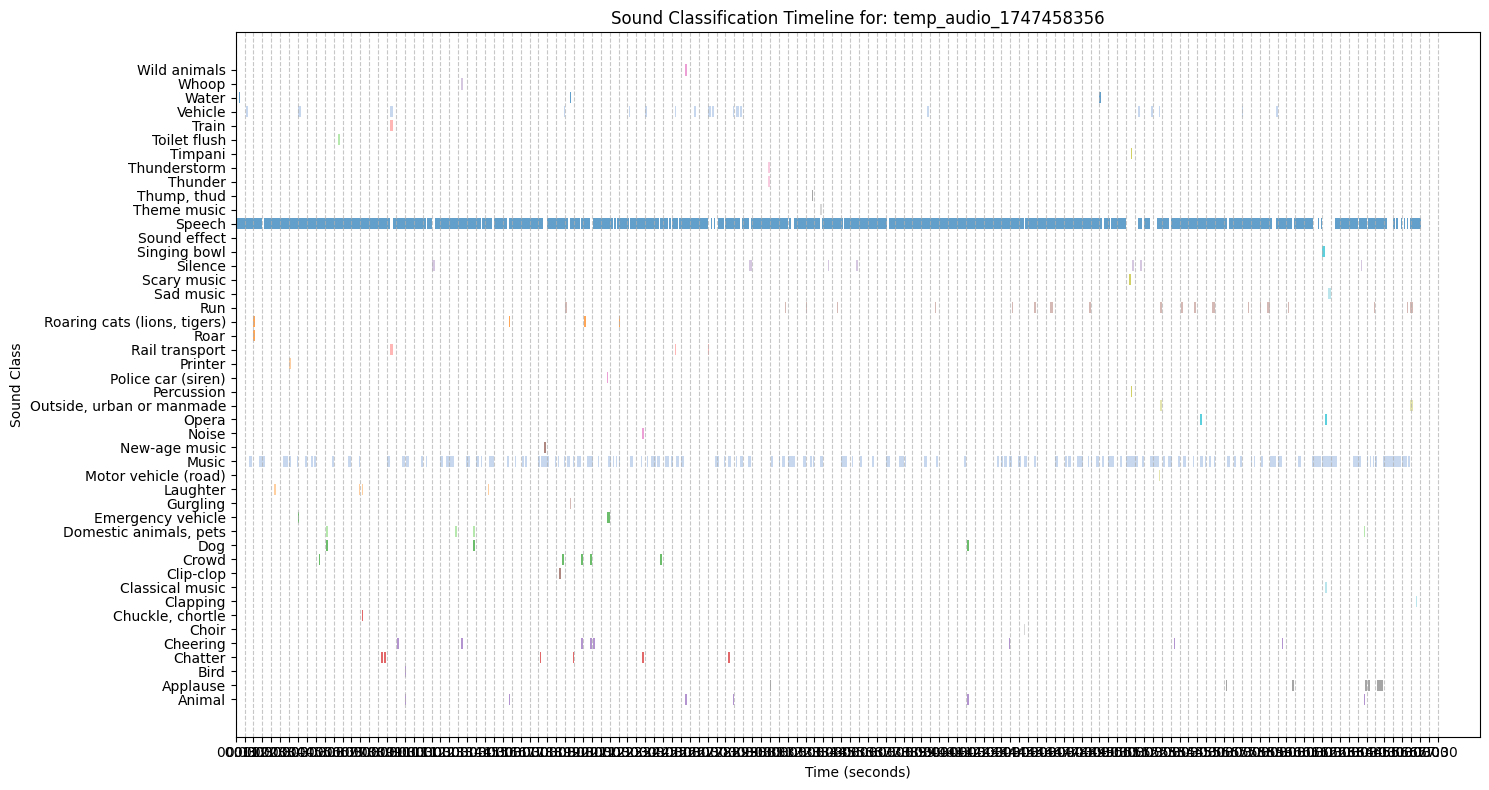

In [14]:
# Run this in a second cell to do the actual classification

# Set your YouTube URL here
youtube_url = "https://www.youtube.com/watch?v=7DzVIafBMpE"  # Using your URL from the error log

# Step 1: Download the audio
wav_file_path, video_title = download_youtube_audio(youtube_url)

if wav_file_path is None:
    print("❌ Failed to download audio. Please check the URL and try again.")
else:
    # Step 2: Analyze the audio
    results = analyze_audio_segments(wav_file_path)

    # Step 3: Display summary of detected sounds
    print("\n🔊 Top detected sounds:")
    sound_summary = results.groupby('class_name')['score'].mean().sort_values(ascending=False).head(10)
    for sound, score in sound_summary.items():
        print(f"- {sound}: {score:.2f}")

    # Step 4: Create visualization
    fig = visualize_sound_timeline(results, video_title)
    fig.show()

    # Step 5: Display timeline as a table - FIXED VERSION
    print("\n⏱️ Sound Timeline (first 10 entries):")
    timeline = results.copy()
    # Sort first by start_time
    timeline = timeline.sort_values('start_time')
    # Then create the formatted time column
    timeline['time_formatted'] = timeline['start_time'].apply(format_time)
    # Now select and rename columns
    timeline = timeline[['time_formatted', 'class_name', 'score']]
    timeline.columns = ['Time', 'Sound', 'Confidence']
    display(timeline.head(10))

    # Step 6: Clean up
    print("\n🧹 Cleaning up temporary files...")
    os.remove(wav_file_path)
    print("✅ Done!")

In [15]:
3992/60

66.53333333333333